<a href="https://colab.research.google.com/github/DiegoMBrito/Sprint_2/blob/main/MVP_Inception_Teste_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de imagens de estruturas geologicas encontradas nas rochas sedimentares, ígneas e metamorficas.

## Discorrer sobre o motivo do estudo....

In [3]:
## 1. Importando e instalando algumas bibliotecas necessárias para executação deste notebook.

!pip install tensorflow
!pip install keras
!pip install pandas
!pip install scikit-learn
!pip install wget
!pip install h5py


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=a109f6b0ac9e97b22df5e357dad903287c11dfe5033e760f8843098330d0c4bc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.applications import InceptionV3
from PIL import Image
import wget
import zipfile
import h5py


In [5]:
# Especifique a URL do arquivo ZIP contendo o diretório
url = 'https://raw.githubusercontent.com/DiegoMBrito/Sprint_2/main/Deep_Learning/Geological_Structures.zip'

# Baixe o arquivo ZIP
wget.download(url, 'Geological_Structures.zip')

# Extraia o arquivo ZIP
with zipfile.ZipFile('Geological_Structures.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# Definir caminhos dos diretórios de treino, validação e teste que estão no github
diretorio_treino = 'Geological_Structures/Train'
diretorio_validacao = 'Geological_Structures/Validation'
diretorio_teste = 'Geological_Structures/Test'

In [7]:
# Definir o tamanho das imagens e o número de classes
input_shape = (256, 256, 3)
num_classes = 9

In [8]:
# Definir os hiperparâmetros do treinamento
batch_size = 128
epochs = 1

In [9]:
# Definir o data augmentation para imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Usar o ImageDataGenerator normal (sem data augmentation) para imagens de validação e teste
validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


In [10]:
# Definir o gerador de dados para as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    diretorio_treino,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    diretorio_validacao,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1350 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 90 images belonging to 9 classes.


In [11]:
# Carregar o modelo InceptionV3 pré-treinado
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [12]:
# Adicionar as suas camadas personalizadas no topo do modelomodel = Sequential()
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
tf.keras.layers.Dropout(0.35),
model.add(Dense(num_classes, activation='softmax'))

In [13]:
# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [15]:
# Treinar o modelo e armazenar o histórico
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

10/10 [==============================] - 327s 32s/step - loss: 2.2079 - accuracy: 0.1776 - val_loss: 2.0249 - val_accuracy: 0.5117


In [16]:
# Salvar o modelo Inception
# model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/Inception_model4.h5')

In [17]:
# Avaliar o modelo no conjunto de teste
# test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
# print('Acurácia no conjunto de teste:', test_accuracy)

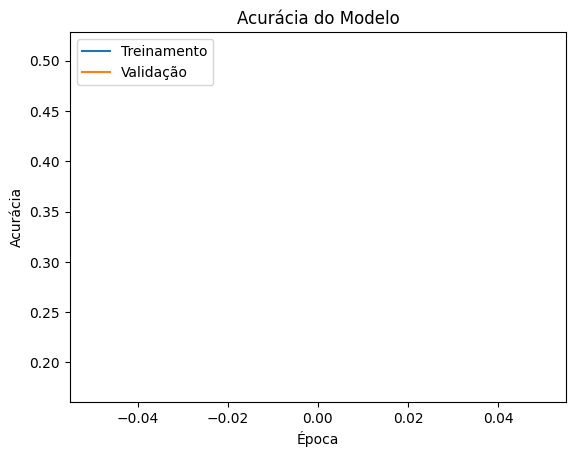

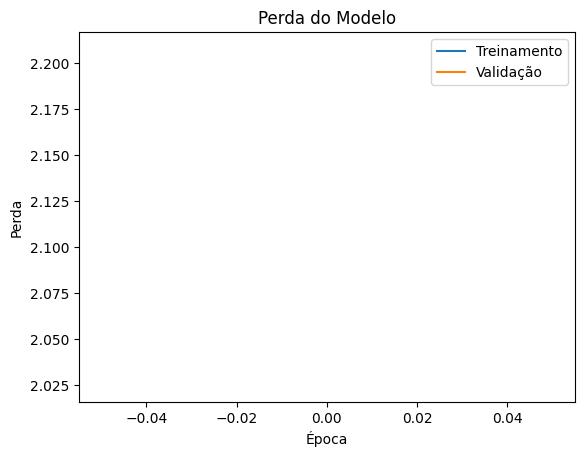

In [18]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

4/4 [==============================] - 24s 6s/step


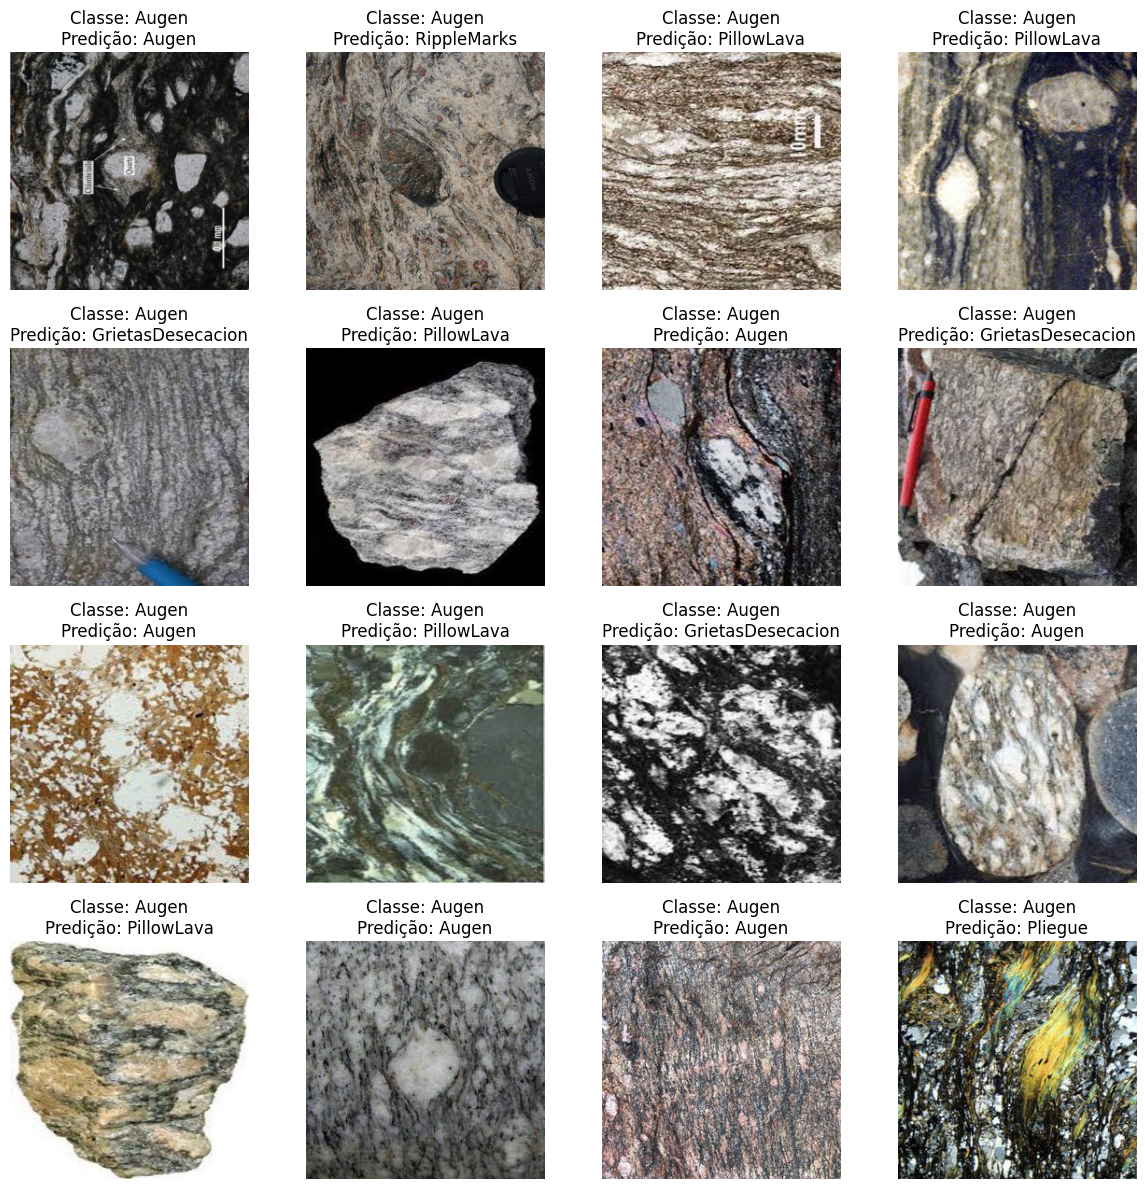

In [19]:
# Visualizar algumas imagens do conjunto de validação e suas classes
class_names = sorted(validation_generator.class_indices.keys())
images, labels = next(validation_generator)
predicted_labels = model.predict(images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i]
    label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])

    ax.imshow(img)
    ax.set_title(f'Classe: {class_names[label]}\nPredição: {class_names[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [20]:
# Fazer previsões nas imagens de teste
predictions = model.predict(test_generator)

1/1 [==============================] - 17s 17s/step


In [21]:
# Obter as classes preditas para cada imagem
predicted_classes = np.argmax(predictions, axis=1)

In [22]:
# Obter as classes reais para cada imagem
true_classes = test_generator.classes

In [23]:
# Obter os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

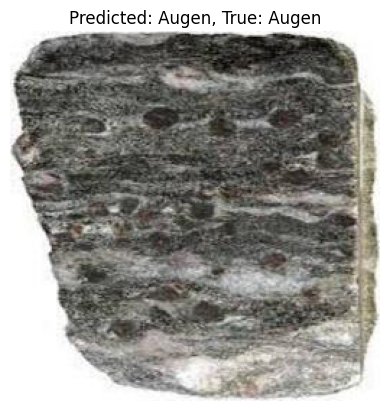

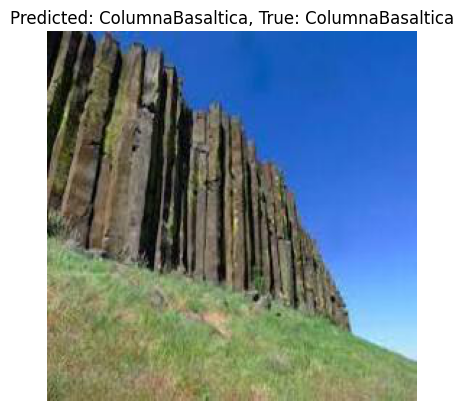

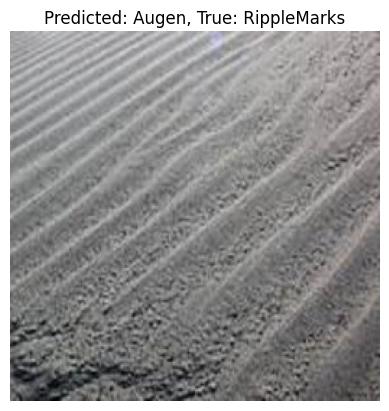

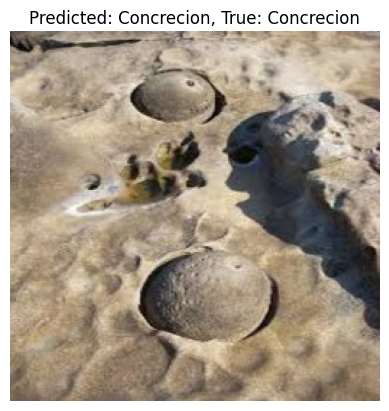

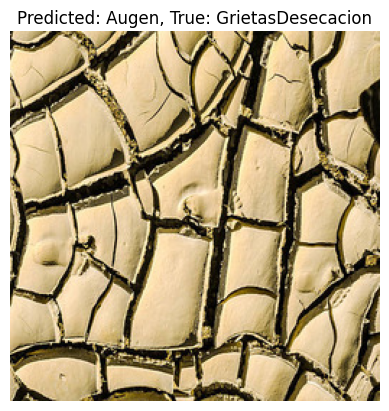

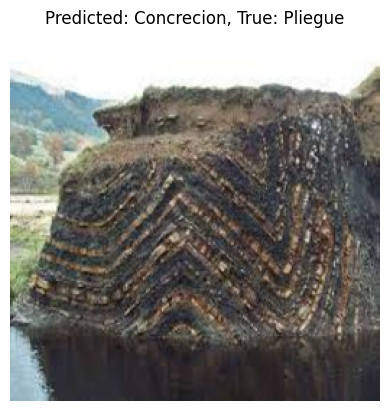

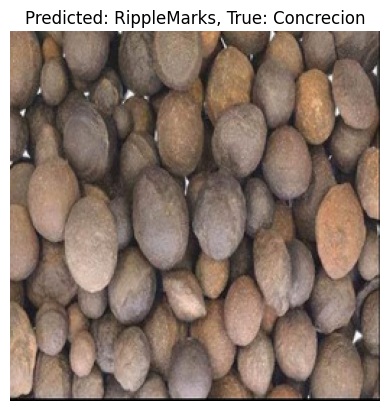

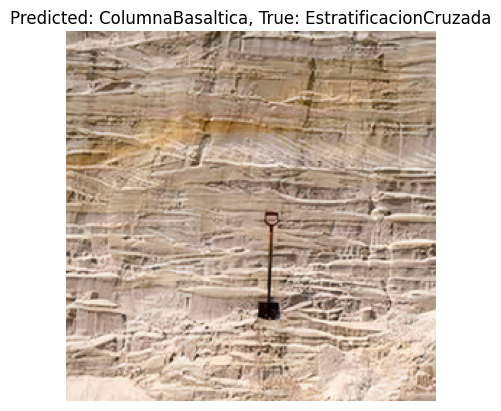

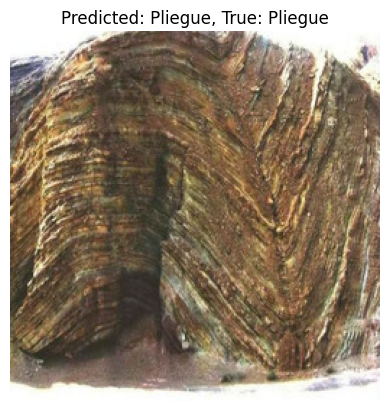

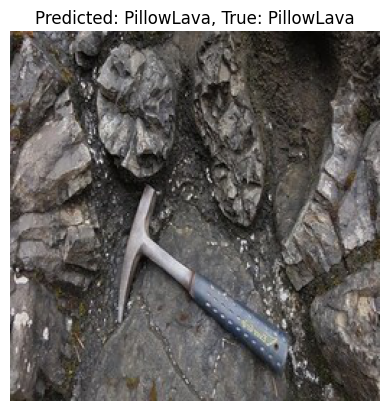

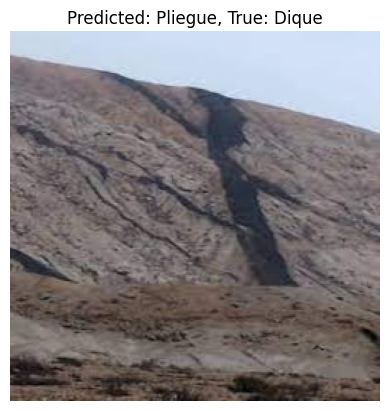

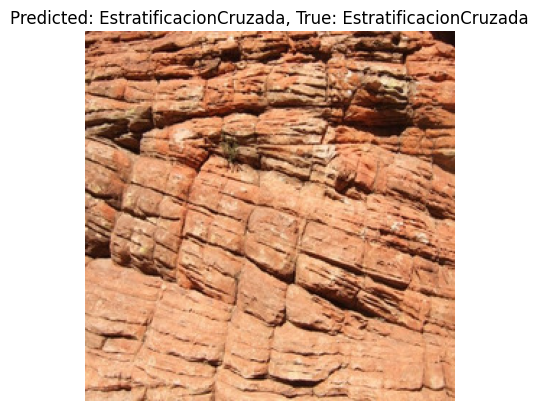

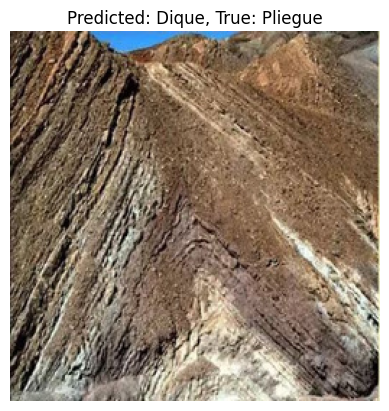

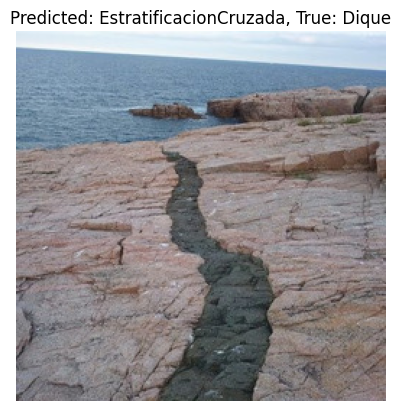

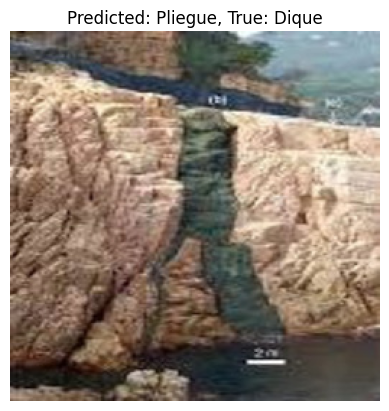

In [24]:
# Mostrar algumas imagens de teste com suas classes preditas e reais
num_images = 15  # Número de imagens para mostrar
sample_indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)
for idx in sample_indices:
    image_path = os.path.join(diretorio_teste, test_generator.filenames[idx])
    image = Image.open(image_path)
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')
    plt.show()

In [25]:
# Importando dados de um aruqivo csv no Google Drive

# imports necessários
from google.colab import drive

# monta o drive
drive.mount("/content/drive")
# neste momento irá aparecer um link do seu goolgedrive para você clicar e copiar um código de acesso ou apenas um poupup de autorização

# carga do dataset earthquake através de um arquivo csv
caminho_modelo = ('drive/My Drive/Pos_Graduacao/Nova_Pasta_Geral/Sprint2/Modelos_Treinados/Inception_model4_cross_validation.h5')

Mounted at /content/drive


In [26]:
# Carregue o modelo treinado
with h5py.File(caminho_modelo, 'r') as arquivo:
    modelo = arquivo.get('Inception_model4_cross_validation.h5')

In [27]:
# Calcular a média e o desvio padrão das métricas de avaliação
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Imprimir os resultados
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Std Accuracy: {std_accuracy}")

NameError: ignored

In [28]:
# Avaliar o modelo nos dados de teste separados
test_data = test_data # Carregar os dados de teste
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

NameError: ignored